In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = data_per_word * len(words)
timesteps = 50
dimensions = 3 * 44

In [3]:
def get_bone_pos(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    bone_pos = np.zeros([44, 3]) # [cooridinates x fingers]
#     finger_tip = {}
    if 'right' in frame['hands']:
        bone_pos[0, :] = np.array([frame['hands']['right']['yaw'], frame['hands']['right']['roll'], frame['hands']['right']['pitch']])
        bone_pos[1, :] = np.array(frame['hands']['right']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[2 + 5 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[2 + 10 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[2 + 15 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['metacarpal']['next_joint'])
    if 'left' in frame['hands']:
        bone_pos[22, :] = np.array([frame['hands']['left']['yaw'], frame['hands']['left']['roll'], frame['hands']['left']['pitch']])
        bone_pos[23, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[4 + 20 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[4 + 25 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[4 + 30 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[4 + 35 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['metacarpal']['next_joint'])

    return bone_pos

In [4]:
import json
import pandas as pd
import numpy as np

In [6]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.array([])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        pick_frame_every_no = len(json_data) / 50 + 1
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            bones_pos = get_bone_pos(frame)
            for idx, bone_pos in enumerate(bones_pos):
                x[word_no * data_per_word + data_no, curr_idx, idx * 3: idx * 3 + 3] = bone_pos
            curr_idx += 1

        y = np.append(y, word_no)

In [9]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x[idx]
        y_train[idx - idx / 3] = y[idx]

In [10]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [11]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [12]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=500, batch_size=8, shuffle=True)

Train on 342 samples, validate on 171 samples
Epoch 1/500
342/342 [==============================] - 4s 12ms/step - loss: 2.9807 - acc: 0.0351 - val_loss: 2.9367 - val_acc: 0.0819
Epoch 2/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9576 - acc: 0.0526 - val_loss: 2.8719 - val_acc: 0.0760
Epoch 3/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9109 - acc: 0.0702 - val_loss: 2.8665 - val_acc: 0.1111
Epoch 4/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9119 - acc: 0.0936 - val_loss: 2.8436 - val_acc: 0.1345
Epoch 5/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8358 - acc: 0.0760 - val_loss: 2.7116 - val_acc: 0.1345
Epoch 6/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8153 - acc: 0.1082 - val_loss: 2.6075 - val_acc: 0.1462
Epoch 7/500
342/342 [==============================] - 2s 6ms/step - loss: 2.7638 - acc: 0.1257 - val_loss: 2.5967 - val_acc: 0.1520
Epoch 8/500
342/342 [=

Epoch 62/500
342/342 [==============================] - 2s 6ms/step - loss: 2.0602 - acc: 0.2778 - val_loss: 2.0441 - val_acc: 0.2690
Epoch 63/500
342/342 [==============================] - 2s 6ms/step - loss: 2.0509 - acc: 0.2778 - val_loss: 2.1142 - val_acc: 0.2924
Epoch 64/500
342/342 [==============================] - 2s 6ms/step - loss: 2.1865 - acc: 0.2690 - val_loss: 2.1865 - val_acc: 0.2398
Epoch 65/500
342/342 [==============================] - 2s 6ms/step - loss: 2.2282 - acc: 0.2368 - val_loss: 2.2602 - val_acc: 0.2047
Epoch 66/500
342/342 [==============================] - 2s 6ms/step - loss: 2.2022 - acc: 0.2632 - val_loss: 2.1094 - val_acc: 0.2690
Epoch 67/500
342/342 [==============================] - 2s 6ms/step - loss: 2.1817 - acc: 0.2222 - val_loss: 2.0814 - val_acc: 0.2924
Epoch 68/500
342/342 [==============================] - 2s 6ms/step - loss: 2.1505 - acc: 0.2456 - val_loss: 2.1118 - val_acc: 0.2982
Epoch 69/500
342/342 [==============================] - 2s 6ms

Epoch 123/500
342/342 [==============================] - 2s 6ms/step - loss: 1.8773 - acc: 0.3187 - val_loss: 1.9779 - val_acc: 0.3450
Epoch 124/500
342/342 [==============================] - 2s 6ms/step - loss: 1.9287 - acc: 0.2895 - val_loss: 1.8939 - val_acc: 0.3626
Epoch 125/500
342/342 [==============================] - 3s 7ms/step - loss: 1.9215 - acc: 0.2924 - val_loss: 1.8352 - val_acc: 0.3450
Epoch 126/500
342/342 [==============================] - 2s 6ms/step - loss: 1.8433 - acc: 0.3450 - val_loss: 1.8617 - val_acc: 0.3509
Epoch 127/500
342/342 [==============================] - 2s 6ms/step - loss: 1.7933 - acc: 0.3538 - val_loss: 1.8554 - val_acc: 0.3684
Epoch 128/500
342/342 [==============================] - 2s 6ms/step - loss: 1.8240 - acc: 0.3363 - val_loss: 1.8295 - val_acc: 0.3801
Epoch 129/500
342/342 [==============================] - 2s 6ms/step - loss: 1.9244 - acc: 0.3333 - val_loss: 1.7935 - val_acc: 0.4035
Epoch 130/500
342/342 [==============================] 

Epoch 244/500
342/342 [==============================] - 2s 6ms/step - loss: 1.7277 - acc: 0.3772 - val_loss: 1.8245 - val_acc: 0.4211
Epoch 245/500
342/342 [==============================] - 2s 6ms/step - loss: 1.6688 - acc: 0.4386 - val_loss: 1.8413 - val_acc: 0.4211
Epoch 246/500
342/342 [==============================] - 2s 6ms/step - loss: 1.5904 - acc: 0.4211 - val_loss: 1.8204 - val_acc: 0.4269
Epoch 247/500
342/342 [==============================] - 2s 6ms/step - loss: 1.5837 - acc: 0.4503 - val_loss: 1.8569 - val_acc: 0.4444
Epoch 248/500
342/342 [==============================] - 2s 7ms/step - loss: 1.5462 - acc: 0.4357 - val_loss: 1.8414 - val_acc: 0.4211
Epoch 249/500
342/342 [==============================] - 2s 6ms/step - loss: 1.5532 - acc: 0.4474 - val_loss: 1.7873 - val_acc: 0.4678
Epoch 250/500
342/342 [==============================] - 3s 8ms/step - loss: 1.5349 - acc: 0.4503 - val_loss: 1.8324 - val_acc: 0.4386
Epoch 251/500
342/342 [==============================] 

Epoch 365/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3490 - acc: 0.4912 - val_loss: 1.9675 - val_acc: 0.4269
Epoch 366/500
342/342 [==============================] - 2s 7ms/step - loss: 1.3912 - acc: 0.4561 - val_loss: 1.9573 - val_acc: 0.4386
Epoch 367/500
342/342 [==============================] - 2s 7ms/step - loss: 1.3855 - acc: 0.4737 - val_loss: 1.9005 - val_acc: 0.4327
Epoch 368/500
342/342 [==============================] - 3s 8ms/step - loss: 1.3915 - acc: 0.4825 - val_loss: 1.9438 - val_acc: 0.4211
Epoch 369/500
342/342 [==============================] - 3s 9ms/step - loss: 1.3908 - acc: 0.4532 - val_loss: 2.0159 - val_acc: 0.4269
Epoch 370/500
342/342 [==============================] - 2s 7ms/step - loss: 1.3739 - acc: 0.4737 - val_loss: 1.9544 - val_acc: 0.4386
Epoch 371/500
342/342 [==============================] - 3s 7ms/step - loss: 1.4126 - acc: 0.4474 - val_loss: 1.9393 - val_acc: 0.4561
Epoch 372/500
342/342 [==============================] 

Epoch 486/500
342/342 [==============================] - 3s 9ms/step - loss: 1.3446 - acc: 0.5146 - val_loss: 1.8798 - val_acc: 0.4444
Epoch 487/500
342/342 [==============================] - 3s 8ms/step - loss: 1.3107 - acc: 0.5058 - val_loss: 1.8463 - val_acc: 0.4386
Epoch 488/500
342/342 [==============================] - 2s 7ms/step - loss: 1.3724 - acc: 0.5000 - val_loss: 1.8705 - val_acc: 0.4386
Epoch 489/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3174 - acc: 0.5205 - val_loss: 1.9047 - val_acc: 0.4211
Epoch 490/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3736 - acc: 0.4971 - val_loss: 1.9330 - val_acc: 0.4269
Epoch 491/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3505 - acc: 0.5088 - val_loss: 1.9766 - val_acc: 0.3977
Epoch 492/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3075 - acc: 0.5000 - val_loss: 1.9678 - val_acc: 0.4035
Epoch 493/500
342/342 [==============================] 

In [14]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 682us/step
('Test score:', 1.9465306725418359)
('Test accuracy:', 0.4385964919252005)


In [15]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


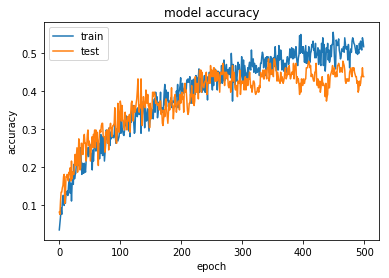

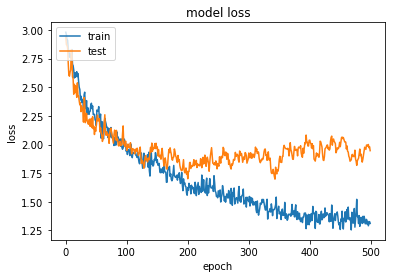

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()